# Frequency Analysis

Run all cells in sequence.

In [3]:
from Methods import *
# from Includes import *
matplotlib.rcParams['figure.dpi'] = 150
%matplotlib inline

In [355]:
def analyze1(x, delays, k, oversample = 1, alpha = 0.9, epsilon = 0.001, delta = 0.1, gamma = 0.01, dtype = 'float', randomize = True, seed = 0, track = False, pad = False):
    N = len(delays)
    x = x.astype(dtype)
    # ds = np.cumsum(delays)
    ds = np.array(delays)
    
    if pad:
        X = np.append(np.zeros(ds[-1], dtype = dtype), x)
    else:
        X = x
    
    A = np.eye(N,k, dtype = dtype)
    Y = np.random.random((N,N)) + (1j if dtype == 'complex' else 0) * np.random.random((N, N))
    Y = Y - np.conj(Y.T)
    if randomize:
        A = scipy.linalg.expm(Y) @ A
    elif seed:
        if seed == 1:
            hop = 1
        else:
            hop = (len(X) - k - ds[-1]) // k
        for i in range(k):
            A[:,i] = X[i * hop + ds[-1] - ds]
        
        # its = range(int(np.sqrt(k)) * N)
        # for i in (tqdm(its) if track else its):
        #     A = A / np.linalg.norm(A, axis = 0)
        #     corr = np.conj(A.T) @ A
        #     C = A @ (np.eye(k) - np.conj(A.T) @ A)
        #     A += (1/N) / (1/N + np.max(np.abs(C))) * C
        
        A[:,0] /= np.linalg.norm(A[:,0])
        for m in range(1, k):
            for l in range(m):
                A[:,m] -= (np.conj(A[:,l]) @ A[:,m]) * A[:,l]
            A[:,m] /= np.linalg.norm(A[:,m])

        
            
    B = np.zeros((N,N), dtype = dtype)
    rate = 0
    
    if pad:    
        trajectory = np.zeros((len(x), k), dtype = dtype)
        bases = np.zeros((len(x), N, k), dtype = dtype)
        distances = np.zeros(len(x), dtype = float)
    else:
        trajectory = np.zeros((len(x) - ds[-1], k), dtype = dtype)
        bases = np.zeros((len(x) - ds[-1], N, k), dtype = dtype)
        distances = np.zeros(len(x) - ds[-1], dtype = float)
    
    try:
        for i in (tqdm(range(ds[-1], len(X))) if track else range(ds[-1], len(X))):
            y = X[i - ds]
            B = alpha * B + (1 - alpha) * np.outer(y, np.conj(y)) # / (gamma + np.conj(y) @ y)
            # rate = np.linalg.norm(y - A @ (np.conj(A.T) @ y)) / np.linalg.norm(y)
            for j in range(oversample):
                # C = B @ A
                # D = (C - A @ (np.conj(A.T) @ C))
                # D = (1 / N) / (1 / N + np.max(np.abs(D))) * D
                # # A += epsilon * np.sqrt(k) * D # subspace learning
                # # A += epsilon * D
                # A += 0.5 * D
                A = B @ A
                A = scipy.linalg.qr(A, mode = 'economic')[0]

                # corr = np.conj(A.T) @ A
                # E = A @ (np.eye(k) - np.conj(A.T) @ A)
                # A += (1/k) / (1/k + np.max(np.abs(E))) * E
                
                # A[:,0] /= np.linalg.norm(A[:,0])
                # for m in range(1,k):
                #     for l in range(m):
                #         A[:,m] -= (np.conj(A[:,l]) @ A[:,m]) * A[:,l]
                #     A[:,m] /= np.linalg.norm(A[:,m])

            trajectory[i - ds[-1]] = np.conj(A.T) @ y
            bases[i - ds[-1]] = A.copy()
            distances[i - ds[-1]] = (np.linalg.norm(y) ** 2 - np.linalg.norm(trajectory[i - ds[-1]]) ** 2) / np.linalg.norm(y) ** 2
    except KeyboardInterrupt:
        return B, trajectory[:i-ds[-1]], bases[:i-ds[-1]], distances[:i-ds[-1]]
    
    return B, trajectory, bases, distances

In [356]:
def analyze(x, delays, k, oversample = 1, alpha = 0.9, epsilon = 0.001, delta = 0.1, gamma = 0.01, dtype = 'float', randomize = True, seed = 0, track = False, pad = False):
    N = len(delays)
    x = x.astype(dtype)
    # ds = np.cumsum(delays)
    ds = np.array(delays)
    
    if pad:
        X = np.append(np.zeros(ds[-1], dtype = dtype), x)
    else:
        X = x
    
    A = np.eye(N,k, dtype = dtype)
    Y = np.random.random((N,N)) + (1j if dtype == 'complex' else 0) * np.random.random((N, N))
    Y = Y - np.conj(Y.T)
    if randomize:
        A = scipy.linalg.expm(Y) @ A
    elif seed:
        if seed == 1:
            hop = 1
        else:
            hop = (len(X) - k - ds[-1]) // k
        for i in range(k):
            A[:,i] = X[i * hop + ds[-1] - ds]
        
        its = range(int(np.sqrt(k)) * N)
        for i in (tqdm(its) if track else its):
            A = A / np.linalg.norm(A, axis = 0)
            corr = np.conj(A.T) @ A
            C = A @ (np.eye(k) - np.conj(A.T) @ A)
            A += (1/N) / (1/N + np.max(np.abs(C))) * C
            
    B = np.zeros((N,N), dtype = dtype)
    rate = 0
    
    if pad:    
        trajectory = np.zeros((len(x), k), dtype = dtype)
        bases = np.zeros((len(x), N, k), dtype = dtype)
        distances = np.zeros(len(x), dtype = float)
    else:
        trajectory = np.zeros((len(x) - ds[-1], k), dtype = dtype)
        bases = np.zeros((len(x) - ds[-1], N, k), dtype = dtype)
        distances = np.zeros(len(x) - ds[-1], dtype = float)
    
    try:
        for i in (tqdm(range(ds[-1], len(X))) if track else range(ds[-1], len(X))):
            y = X[i - ds]
            B = alpha * B + (1 - alpha) * np.outer(y, np.conj(y)) / (gamma + np.conj(y) @ y)
            
            for j in range(oversample):
                A = B @ A
                
                # A[:,0] = A[:,-1]
                A[:,0] /= np.linalg.norm(A[:,0])
                for m in range(1, k):
                    A[:,m] = B @ A[:,m-1]
                    A[:,m] /= np.linalg.norm(A[:,m])
                    for l in range(m):
                        A[:,m] -= (np.conj(A[:,l]) @ A[:,m]) * A[:,l]
                        

#                 A = A / np.linalg.norm(A, axis = 0) # orthogonalization
#                 corr = np.conj(A.T) @ A
#                 E = A @ (np.eye(k) - np.conj(A.T) @ A)
#                 A += (1/k) / (1/k + np.max(np.abs(E))) * E

                
            trajectory[i - ds[-1]] = np.conj(A.T) @ y
            bases[i - ds[-1]] = A
            distances[i - ds[-1]] = (np.linalg.norm(y) ** 2 - np.linalg.norm(trajectory[i - ds[-1]]) ** 2) / np.linalg.norm(y) ** 2
    except KeyboardInterrupt:
        return B, trajectory[:i-ds[-1]], bases[:i-ds[-1]], distances[:i-ds[-1]]
    
    return B, trajectory, bases, distances

In [487]:

def analyze(x, delays, k, oversample = 1, alpha = 0.999, epsilon = 0.0001, delta = 0.01, gamma = 0.01, normalize = False, dtype = 'float', randomize = True, mode = 'qr', corrected = True, pad = False):
    N = len(delays)
    x = x.astype(dtype)
    # ds = np.cumsum(delays)
    ds = np.array(delays)
    
    if pad:
        X = np.append(np.zeros(ds[-1], dtype = dtype), x)
    else:
        X = x
         
    A = np.eye(N,k, dtype = dtype)
    Y = np.random.random((N,N)) + (1j if dtype == 'complex' else 0) * np.random.random((N, N))
    Y = Y - np.conj(Y.T)
    if randomize:
        A = scipy.linalg.expm(Y) @ A
    
    B = np.zeros((N,N), dtype = dtype)
    
    if pad:    
        trajectory = np.zeros((len(x), k), dtype = dtype)
        bases = np.zeros((len(x), N, k), dtype = dtype)
        distances = np.zeros(len(x), dtype = float)
        sep = np.zeros(len(x), dtype = dtype)
    else:
        trajectory = np.zeros((len(x) - ds[-1], k), dtype = dtype)
        bases = np.zeros((len(x) - ds[-1], N, k), dtype = dtype)
        distances = np.zeros(len(x) - ds[-1], dtype = float)
        sep = np.zeros(len(x) - ds[-1], dtype = dtype)

    
    try:
        for i in tqdm(range(ds[-1], len(X))):
            y = X[i - ds]
            if normalize:
                B = alpha * B + (1 - alpha) * np.outer(y, np.conj(y)) / (gamma + np.conj(y) @ y)
            else:
                B = alpha * B + (1 - alpha) * np.outer(y, np.conj(y))
                
            for j in range(oversample):
                
                Z = B @ A
                if mode == 'gradient':
                    A += epsilon * np.sqrt(N * k) * (Z - A @ (np.conj(A.T) @ Z))

                    A = A / np.linalg.norm(A, axis = 0) # orthogonalization
                    corr = np.conj(A.T) @ A
                    E = A @ (np.eye(k) - np.conj(A.T) @ A)
                    A += (1 / k) / (1 / k + np.max(np.abs(E))) * E
                    
                elif mode == 'qr':
                    C, D = scipy.linalg.qr(Z, mode = 'economic')
                    new = C

                    if corrected:
                        # if new and A have similar images, this will be close to a rotation matrix
                        Y = np.conj(new.T) @ A

                        # find the closest k x k unitary matrix
                        u, d, v = scipy.linalg.svd(Y, full_matrices = False)
                        Y = u @ v
                    else:
                        Y = np.eye(k)

                    # spin new so that it is close to the old A
                    A = new @ Y

                elif mode == 'svd':
                    # correct Z to an orthonormal basis, C
                    u, d, v = scipy.linalg.svd(Z, full_matrices = False)
                    C = u @ v
                    
                    if corrected:
                        Y = np.conj(C.T) @ A
                        
                        # find the closest k x k unitary matrix
                        u, d, v = scipy.linalg.svd(Y, full_matrices = False)
                        Y = u @ v
                    else:
                        Y = np.eye(k)

                    # spin C so that it is close to the old A
                    A = C @ Y
                    
            trajectory[i - ds[-1]] = np.conj(A.T) @ y
            bases[i - ds[-1]] = A
            if normalize:
                distances[i - ds[-1]] = np.real((np.conj(y) @ y - np.conj(trajectory[i - ds[-1]]) @ trajectory[i - ds[-1]]) / (gamma + np.conj(y) @ y))
            else:
                distances[i - ds[-1]] = np.real((np.conj(y) @ y - np.conj(trajectory[i - ds[-1]]) @ trajectory[i - ds[-1]]))
                
            sep[i - ds[-1]] = (y - A @ trajectory[i - ds[-1]])[0]
    except KeyboardInterrupt:
        return trajectory[:i-ds[-1]], bases[:i-ds[-1]], distances[:i-ds[-1]], sep[:i-ds[-1]]
    
    return trajectory, bases, distances, sep


Original vectors & correlation
Orthogonal defect: 0.9952029502274647


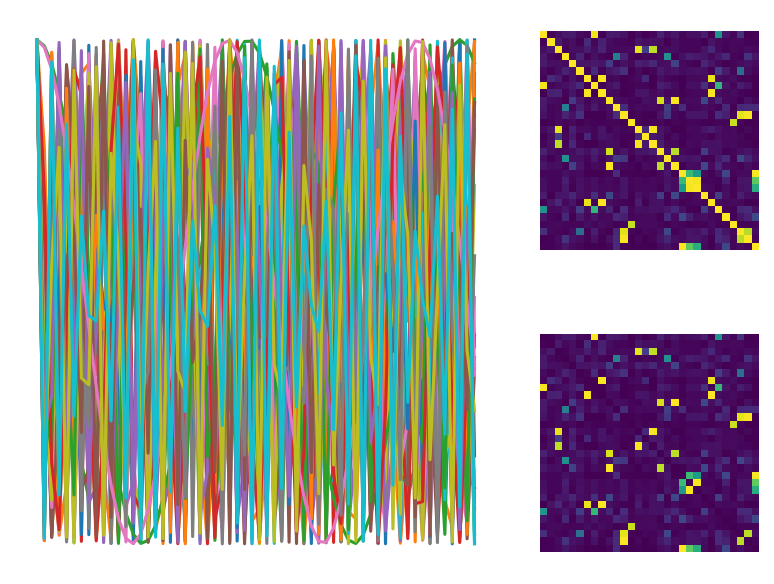

In [513]:
k = 30 # number of frequencies
SR = 48000 # sample rate
bandlimit = 2 # restrict frequencies to [0, SR / bandlimit]

fs = np.random.rand(k) * SR / bandlimit # generate random freqs

# N = bandlimit * k # set embedding dimension
N = k * bandlimit
# M = bandlimit * N # set dimension for extra rollover
M = 2 * k * N

phasor = 2 * np.pi * np.arange(0, M / SR, 1 / SR)
phases = np.array([phasor * f for f in fs])
source = np.exp(1j * phases)
vectors = source[:,:N]
vectors = (vectors.T / np.linalg.norm(vectors.T, axis=0)).T

print("Original vectors & correlation")
print("Orthogonal defect:", np.max(np.abs(np.conj(vectors) @ vectors.T - np.eye(k))))

fig = plt.figure()
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan = 2, colspan = 2)
ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
ax3 = plt.subplot2grid((2, 3), (1, 2), colspan=1)

ax1.plot(np.real(vectors.T[:]))
ax2.imshow(np.abs(np.conj(vectors) @ vectors.T))
ax3.imshow(np.abs(np.conj(vectors) @ vectors.T - np.eye(k)))

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

plt.show()

In [514]:
# synthetic estimate
B = vectors.T.copy()

Orthogonalized synthetic vectors
Orthogonal defect: 8.88178888584294e-16


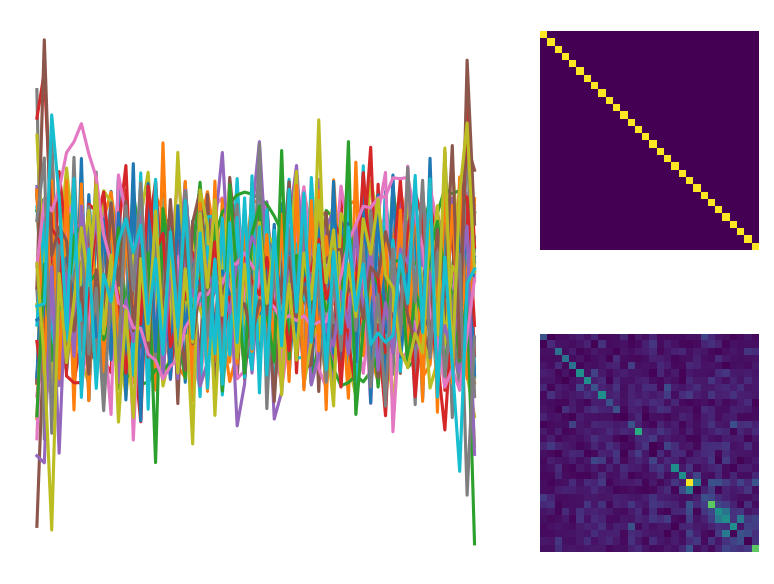

In [515]:
# for i in tqdm(range(bandlimit * k)):
#     B = B / np.linalg.norm(B, axis = 0)
#     corr = np.conj(B.T) @ B
#     C = B @ (np.eye(k) - np.conj(B.T) @ B)
#     B += (1/k) / (1/k + np.max(np.abs(C))) * C

# B[:,0] /= np.linalg.norm(B[:,0])
# for m in range(1, k):
#     # B[:,m] /= np.linalg.norm(B[:,m])
#     for l in range(m):
#         B[:,m] -= (np.conj(B[:,l]) @ B[:,m]) * B[:,l]
#     B[:,m] /= np.linalg.norm(B[:,m])

B = scipy.linalg.qr(B, mode = 'economic')[0]


fig = plt.figure()
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan = 2, colspan = 2)
ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
ax3 = plt.subplot2grid((2, 3), (1, 2), colspan=1)

ax1.plot(np.real(B[:]))
ax2.imshow(np.abs(np.conj(B.T) @ B))
ax3.imshow(np.abs(np.conj(B.T) @ B - np.eye(k)))

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

print("Orthogonalized synthetic vectors")
print("Orthogonal defect:", np.max(np.abs(np.conj(B.T) @ B - np.eye(k))))

plt.show()

In [516]:
# "observed", i.e. delay-embedded
coeffs = np.ones(k)
signal = source.T @ coeffs

trajectory, bases, distances, sep = analyze(signal, list(range(N)), k, dtype = 'complex', randomize = True, mode = 'qr', corrected = True, normalize = False, oversample = 1)
A = np.conj(bases[-1])
# A = bases[-1]

  7%|██████▉                                                                                                  | 232/3541 [00:27<06:37,  8.33it/s]


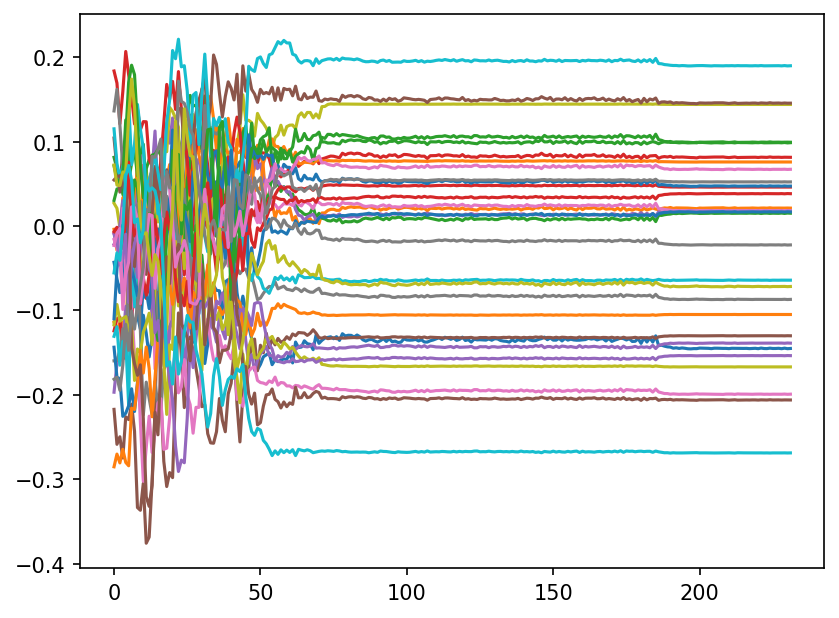

In [530]:
plt.plot(bases[:,0,:])
plt.show()

Orthogonalized vectors learned from delay embedding
Projection defect: 0.0
Orthogonal defect: 9.992019257423656e-16


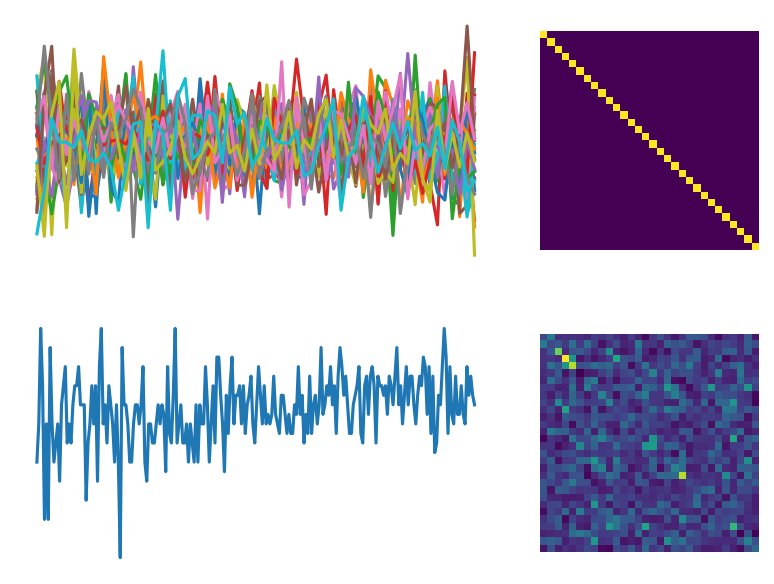

In [518]:
fig = plt.figure()
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan = 1, colspan = 2)
ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
ax3 = plt.subplot2grid((2, 3), (1, 2), colspan=1)
ax4 = plt.subplot2grid((2, 3), (1, 0), colspan=2)

ax1.plot(np.real(A[:]))
ax2.imshow(np.abs(np.conj(A.T) @ A))
ax3.imshow(np.abs(np.conj(A.T) @ A - np.eye(k)))
ax4.plot(distances)

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax4.set_axis_off()

print("Orthogonalized vectors learned from delay embedding")
print("Projection defect:", distances[-1])
print("Orthogonal defect:", np.max(np.abs(np.conj(A.T) @ A - np.eye(k))))

plt.show()

In [531]:
print("Estimate from delay embedding and subspace learning:\n")

# generate random orthogonal matrix to right-mult by
# Y = np.random.random((k,k)) + 1j * np.random.random((k, k))
# Y = Y - np.conj(Y.T)
# X = scipy.linalg.expm(Y)

# mix up A by a random orthogonal matrix
Z = A
S = np.linalg.inv(np.conj(Z[:-1,:].T) @ Z[:-1,:]) @ np.conj(Z[:-1,:].T) @ Z[1:,:]

omegas = np.linalg.eigvals(S)

freqs = np.sort([np.angle(o) * SR / (2 * np.pi) for o in omegas])[::-1]
fs = np.sort(fs)[::-1]

print("Detected:", freqs, "\n")

print("True:", fs, "\n")

# compute errors by comparing each estimated frequency from freqs
# to nearest element of the true frequencies, fs
errs = np.zeros(k)

for i,f in enumerate(freqs):
    a = np.argmin(np.abs(f - fs))
    errs[i] = f - fs[a]

print("Errors", errs, "\n")

magnitude = np.log(np.abs(errs[errs != 0]))
mean = np.mean(magnitude[magnitude != -np.inf]) if len(magnitude) else 0

# typical accuracy is has the average order of magnitude of error in frequency
print("Typical accuracy:", np.exp(mean),"Hz.\n", "Worst case:", np.max(np.abs(errs)),"Hz.\n", "Best case:", np.min(np.abs(errs)),"Hz.\n")

Estimate from delay embedding and subspace learning:

Detected: [22794.86617459 22712.02444447 22389.34347137 22337.83318248
 21246.17929145 20342.97105491 19820.64555204 19340.54488452
 19048.634746   18423.3028074  18217.44265611 17673.83414725
 16848.94580633 16769.6548613  16375.11352578 15366.95090755
 14286.21661432 14250.19478338 14077.20515384 13248.77836979
 11146.19180309 11071.2917437  10947.27802702  9650.10223306
  8855.49253268  8802.18851903  8742.8554007   7335.81480431
  1868.01237194  1682.96695091] 

True: [22794.85731913 22712.02349183 22389.34212685 22337.85179297
 21246.17994406 20342.94656231 19820.55722242 19340.60369731
 18444.73152691 18371.57752865 18236.17670038 17672.44302164
 16847.10530327 16759.44257374 16375.63210233 15366.99460656
 14280.56939704 14237.33035894 14077.69078172 13248.77838572
 11146.19655287 11071.23467095 10947.2818141   9650.10225043
  8855.47174218  8802.17227899  8742.86110812  7335.81480392
  1868.01237183  1682.96695099] 

Errors [

In [447]:
print("Synthetic estimate (from orthogonalizing sinusoids directly)\n")

Y = np.random.random((k,k)) + 1j * np.random.random((k, k))
Y = Y - np.conj(Y.T)
X = scipy.linalg.expm(Y)

# mix up by a random orthogonal matrix
Z = B @ X
S = np.linalg.inv(np.conj(Z[:-1,:].T) @ Z[:-1,:]) @ np.conj(Z[:-1,:].T) @ Z[1:,:]

omegas = np.linalg.eigvals(S)

freqs = np.sort([np.angle(o) * SR / (2 * np.pi) for o in omegas])
fs = np.sort(fs)

print("Detected:", freqs, "\n")

print("True:", fs, "\n")

# compute errors by comparing each estimated frequency from freqs
# to nearest element of the true frequencies, fs
errs = np.zeros(k)

for i,f in enumerate(freqs):
    a = np.argmin(np.abs(f - fs))
    errs[i] = f - fs[a]

print("Errors", errs, "\n")

magnitude = np.log(np.abs(errs[errs != 0]))
mean = np.mean(magnitude[magnitude != -np.inf]) if len(magnitude) else -np.inf

# typical accuracy is has the average order of magnitude of error in frequency
print("Typical accuracy:", np.exp(mean),"Hz.\n", "Worst case:", np.max(np.abs(errs)),"Hz.\n", "Best case:", np.min(np.abs(errs)),"Hz.\n")

Synthetic estimate (from orthogonalizing sinusoids directly)

Detected: [  441.83740194  1007.6598052   1598.2565326   1631.43498624
  2743.66824679  4070.28045101  4371.56301072  4763.97723589
  7593.53099023  7635.43032963  8564.14040332  8707.1365831
  8994.15917565  9311.65447848  9314.1457828   9980.97722078
 11766.97360904 11800.41049051 12367.78149744 13821.24030529
 15505.56170294 15641.61432602 16139.19228036 16188.21345883
 16874.2855341  20355.16595076 21387.46099239 21413.63367708
 22436.32589767 22922.31232342] 

True: [  441.83740194  1007.6598052   1598.2565326   1631.43498624
  2743.66824679  4070.28045101  4371.56301072  4763.97723589
  7593.53099023  7635.43032963  8564.14040334  8707.13658302
  8994.15917566  9311.6544814   9314.14578013  9980.97722078
 11766.97360904 11800.41049051 12367.78149744 13821.24030529
 15505.56170294 15641.61432602 16139.19228036 16188.21345883
 16874.2855341  20355.16595076 21387.46099239 21413.63367708
 22436.32589767 22922.31232342] 

E